In [1]:
import sys
import pandas as pd

sys.path.append('/opt/hydra/')

import library.analysis as hydra

In [9]:
exp_path = '../data/treehouse-synovial-log2TPM1-V9.tsv'
mm_path = '../data/synovial-output/MultiModalGenes'

In [5]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [10]:
import numpy as np

sweep_terms = {}
sweep_genes = {}
for x in np.linspace(0.2, 0.35, 6):

    mm = hydra.EnrichmentAnalysis(mm_path,
                                  exp_path,
                                  min_prob_filter=x,
                                  gmt_path='GO')
    
    print 'Min Prob: ', x
    print 'Num Genes: ', len(mm.get_enriched_term_genes())
    print mm.get_enriched_terms()
    print
    
    sweep_terms[x] = mm.get_enriched_terms()
    sweep_genes[x] = mm.get_enriched_term_genes()

Min Prob:  0.2
Num Genes:  53
   Unnamed: 0          ID                                        Description  \
0  GO:0007389  GO:0007389                      pattern specification process   
1  GO:0098742  GO:0098742  cell-cell adhesion via plasma-membrane adhesio...   
2  GO:2000615  GO:2000615            regulation of histone H3-K9 acetylation   

  GeneRatio    BgRatio        pvalue      p.adjust        qvalue  \
0    36/321  333/11960  7.848287e-13  2.655860e-09  2.442057e-09   
1    14/321  147/11960  4.054792e-05  3.920405e-03  3.604801e-03   
2     4/321   11/11960  1.447669e-04  1.042322e-02  9.584122e-03   

                                              geneID  Count  
0  IRX1/IRX2/GATA4/ZIC3/HOXB8/HOXB3/HOXB4/HOXC11/...     36  
1  PCDH11X/ADGRL3/CDH8/CLDN4/AMIGO2/PCDHB7/PCDHGA...     14  
2                          GATA3/NAP1L2/PIWIL2/KMT2A      4  

Min Prob:  0.23
Num Genes:  49
   Unnamed: 0          ID                                        Description  \
0  GO:0007389  G

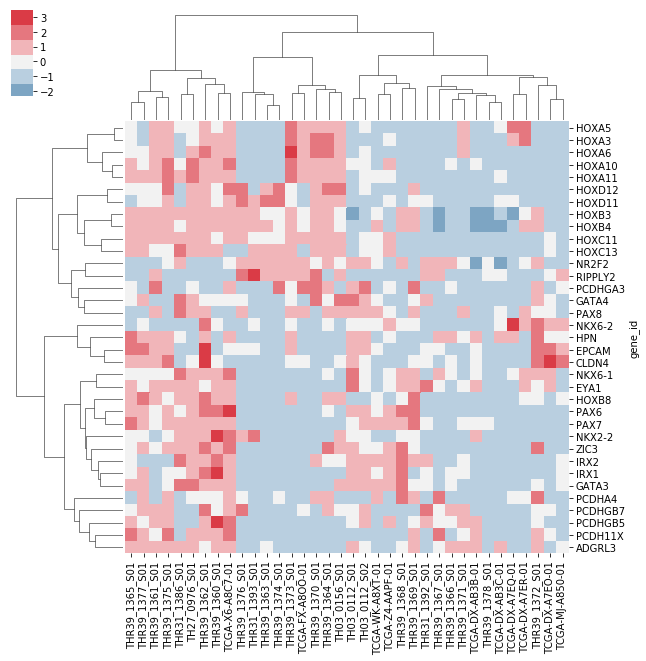

In [11]:
hclust = hydra.HClust(exp.reindex(sweep_genes[0.29]))
hclust.plot()

In [12]:
sweep_assign = {}
for key, genes in sweep_genes.items():
    clus = hydra.MultivariateMixtureModel(data=exp.reindex(genes),
                                          center=True,
                                          gamma=5.0,
                                          variance=2.0,
                                          K=1)
    
    print 'Min Prob: ', key
    print 'Num Genes: ', len(genes) 
    print len(clus.hmodel.allocModel.get_active_comp_probs())
    sweep_assign[key] = clus.get_assignments(exp.reindex(genes))

DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
DELETE @ lap 2.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 3.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 4.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 5.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 3 have past failures.
DELETE @ lap 6.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 3 have past failures.
DELETE @ lap 7.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 3 have past failures.
DELETE @ lap 8.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 9.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 10.00: 0/1 accepted. Ndiff 0.00.
DELETE @ lap 11.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0 too big. 3 have past failures.
DELETE @ lap 12.00: Empty plan. 0 UIDs eligible as delete target. 0 too busy with other moves. 0

In [ ]:
import uuid
import subprocess
from scipy.stats import ttest_ind

sweep_cluster_gsea = {}
for key, assign in sweep_assign.items():
    print key
    sweep_cluster_gsea[key] = {}
    
    if max(assign) == 0:
        continue 
        
    for group in sorted(list(set(assign))):
        ins = []
        outs = []
        for sample, _assign in zip(exp.columns, assign):
            if _assign == group:
                ins.append(sample)
            
            else:
                outs.append(sample)
                
        res = ttest_ind(exp[ins].values,
                        exp[outs].values,
                        axis=1).statistic
        
        tstats = pd.DataFrame(index=exp.index, 
                              data=res).dropna()
            
        tstats = tstats.sort_values(0, 
                                    ascending=False).reset_index()
        
        fname = '/tmp/%s' % str(uuid.uuid4())
        rname = '/tmp/%s' % str(uuid.uuid4())
        tstats.to_csv(fname,
                      header=None,
                      sep='\t',
                      index=False)
            
        cmd = ["Rscript",
               "/opt/hydra/bin/fgsea.R",
               "/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt",
               fname,
               rname]
                
        subprocess.check_call(cmd)
        fgsea = pd.read_csv(rname)
        sweep_cluster_gsea[key][group] = fgsea[fgsea['padj'] < 0.05].sort_values('NES', ascending=False)

0.29


In [ ]:
sweep_cluster_gsea[0.29][0].head(10)

In [ ]:
sweep_cluster_gsea[0.29][1].head(20)

In [ ]:
sweep_cluster_gsea[0.29][2].head(10)

In [ ]:
assign = pd.DataFrame(columns=['sample', 'cluster'])
for s, a in zip(exp.columns, sweep_assign[0.29]):
    assign.loc[len(assign), :] = [s, a + 1]

In [ ]:
assign.set_index('sample').to_csv('synovial-hydra-assignments.tsv',
                                  sep='\t')

In [ ]:
pth = 'synovial-fusion.tsv'
fusion = pd.read_csv(pth, sep='\t', index_col=0)

In [ ]:
m = [[0, 0, 0], [0, 0, 0]]
for sample in assign.index.values:
    if sample == 'TCGA-DX-A7EQ-01':
        continue
    c = assign.loc[sample, 'cluster']
    f = fusion.loc[sample, 'fusion']
    if f == 'SSX1':
        m[1][c - 1] += 1
        
    elif f == 'SSX2':
        m[0][c - 1] += 1
    
    else:
        raise ValueError()

In [ ]:
"""
> library(stats)
> library(base)
> x <- rbind(c(4, 5, 2), c(13, 5, 6))
> x
     [,1] [,2] [,3]
[1,]    4    5    2
[2,]   13    5    6
> fisher.test(x)

	Fisher's Exact Test for Count Data

data:  x
p-value = 0.3237
alternative hypothesis: two.sided
"""

In [ ]:
fusion_samples = {'SSX1': [], 'SSX2': []}